In [119]:
from neuralop.models import FNO
from fno_dataset import *

In [ ]:
from datetime import datetime
train_loader = SEVIRDataLoader(start_date=datetime(2018, 1, 1), end_date=datetime(2018, 5, 1), batch_size=4, shuffle=True, seq_len=8, stride = 20, rescale_method='01', preprocess=True)
test_loader = SEVIRDataLoader(start_date=datetime(2017, 1, 1), end_date=datetime(2017, 7, 1), batch_size=4, shuffle=False, seq_len=8, stride = 20, rescale_method='01', preprocess=True)
val_loader = SEVIRDataLoader(start_date=datetime(2019, 1, 1), end_date=datetime(2019, 9, 1), batch_size=4, shuffle=False, seq_len=8, stride = 4, rescale_method='01', preprocess=True)
print("Train dataset size:", len(train_loader))
print("Test dataset size:", len(test_loader))
print("Validation dataset size:", len(val_loader))
for loader in [train_loader, test_loader, val_loader]:
    for sample in loader:
        data = sample['vil']
        print("Data shape:", data.shape)
        print("Data min:", data.min().item(), "max:", data.max().item())
        break
    

Train dataset size: 1383
Test dataset size: 371
Validation dataset size: 13246
Data shape: torch.Size([4, 384, 384, 8])
Data min: 0.0 max: 0.9568628072738647
Data shape: torch.Size([4, 384, 384, 8])
Data min: 0.0 max: 0.9960784912109375
Data shape: torch.Size([4, 384, 384, 8])
Data min: 0.0 max: 0.46666669845581055


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import time
torch.autograd.set_detect_anomaly(True)

os.makedirs('fno_plots', exist_ok=True)

model = FNO(n_modes=(64, 64), hidden_channels=128, in_channels=4, out_channels=4)
model.load_state_dict(torch.load('/home/vatsal/NWM/fno_sevir/fno_model_1748161739.pth', weights_only=False))
model = model.to('cuda')


In [127]:
def plot(target_frames, predicted_frames, vil_colormap, vil_norm, epoch, batch_idx=0):
    num_frames = predicted_frames.shape[1]
    fig, axes = plt.subplots(2, num_frames, figsize=(2*num_frames, 6))
    fig.suptitle(f'Epoch {epoch+1} - Predicted vs Target Frames', fontsize=16)
    # Move to cpu and scale to 0-255 for visualization
    pred_np = predicted_frames[0].detach().cpu().numpy() * 255
    target_np = target_frames[0].detach().cpu().numpy() * 255
    pred_np = np.clip(pred_np, 0, 255).astype(np.uint8)
    target_np = np.clip(target_np, 0, 255).astype(np.uint8)
    
    for i in range(num_frames):
        axes[0, i].imshow(target_np[i], cmap=vil_colormap, norm=vil_norm)
        axes[0, i].set_title(f'Target Frame {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(pred_np[i], cmap=vil_colormap, norm=vil_norm)
        axes[1, i].set_title(f'Predicted Frame {i+1}')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()
vil_colormap, vil_norm = vil_cmap(encoded=True)
print(vil_norm)


In [ ]:
for sample in train_loader:
    pass

In [148]:
train_loader.reset()

In [140]:
x = 0
for sample in train_loader:
    data = sample['vil'].clone()
    print("Data shape:", data.shape)
    print("Data min:", data.min().item(), "max:", data.max().item())
    data = data.to("cuda")
    data = data.permute(0, 3, 1, 2)  # Change to (batch_size, channels, height, width)
    input = data[:, :4, :, :]  # Use first 4 channels as input
    target = data[:, 4:, :, :]  # Use last 4 channels as target
    with torch.no_grad():
        pred = model(input)
        
    plot(target, input, vil_colormap,vil_norm, epoch=0)
    x += 1
    if x > 5:
        break

Epoch 1/5 [Train]:   0%|          | 0/1383 [00:00<?, ?it/s]

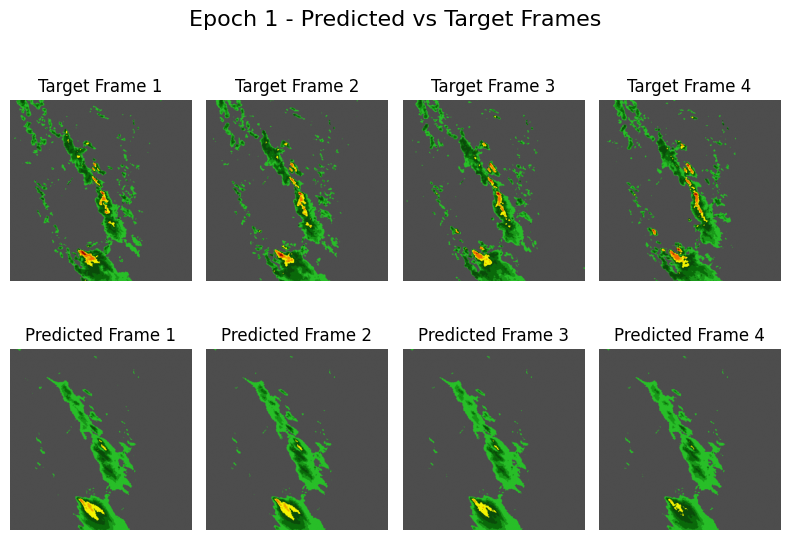

Epoch 1/5 [Test]:   0%|          | 0/371 [00:00<?, ?it/s, Loss=0.0038]

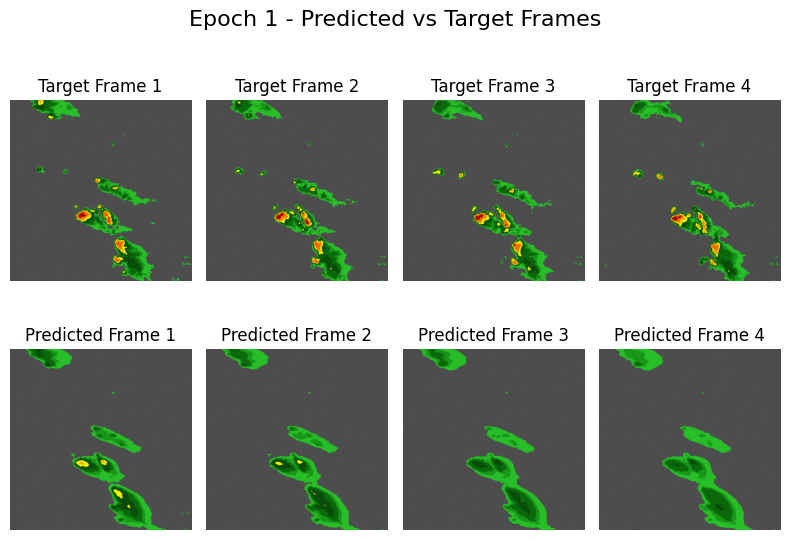

Epoch 1/5 [Test]:  27%|██▋       | 100/371 [00:12<00:32,  8.27it/s, Loss=0.0107]

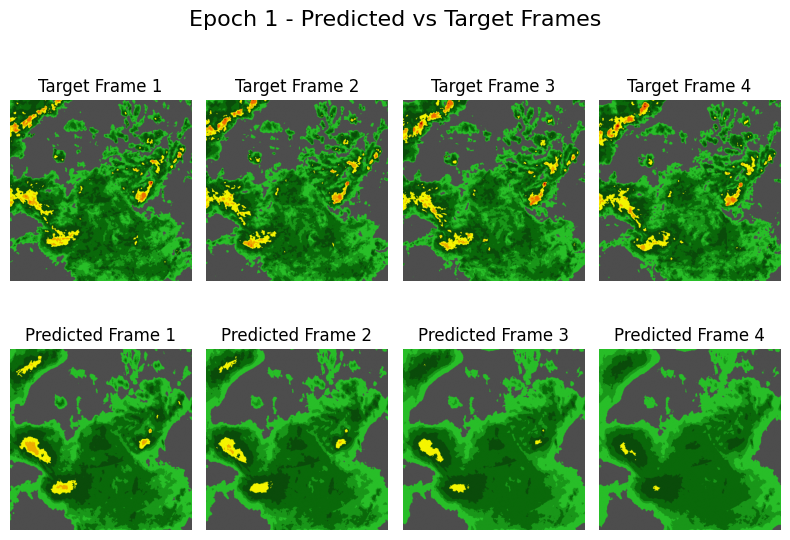

Epoch 1/5 [Test]:  54%|█████▍    | 200/371 [00:25<00:20,  8.34it/s, Loss=0.0067]

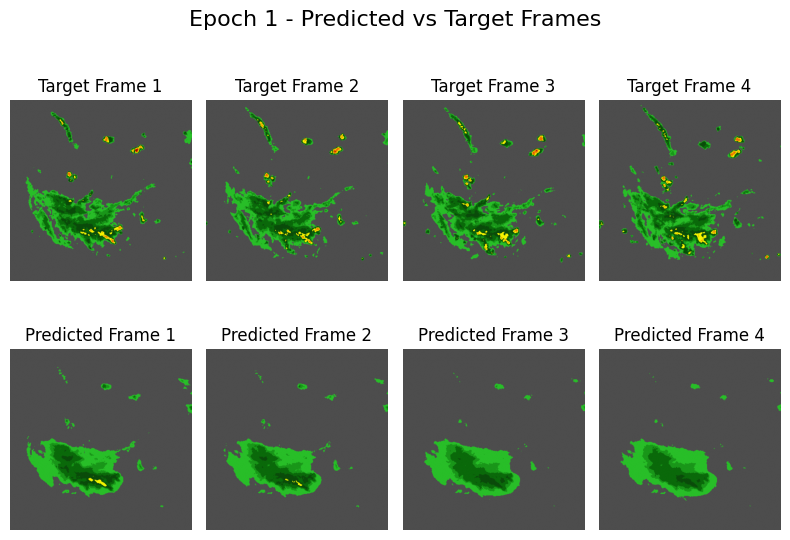

Epoch 1/5 [Test]:  81%|████████  | 300/371 [00:38<00:08,  7.90it/s, Loss=0.0106]

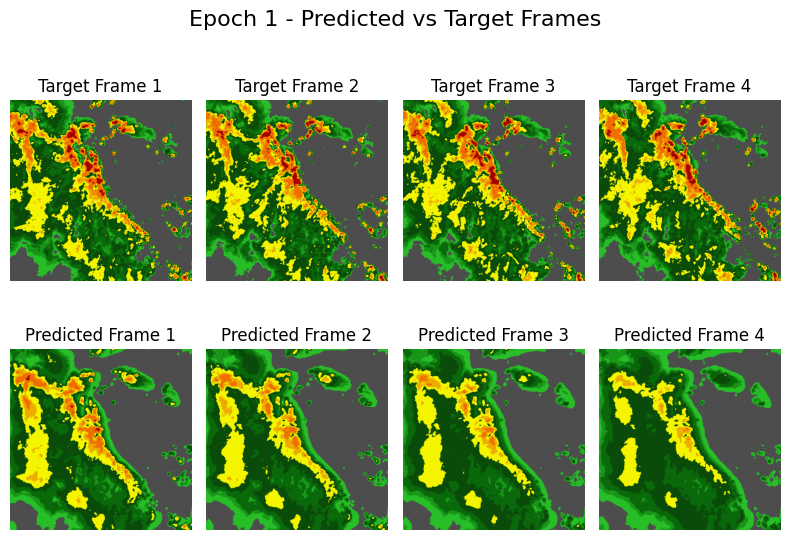

Epoch 1/5 [Test]: 100%|██████████| 371/371 [00:47<00:00,  7.79it/s, Loss=0.0042]


Epoch 1 - Train Loss: 0.0042, Test Loss: 0.0068


Epoch 2/5 [Test]:   0%|          | 0/371 [00:00<?, ?it/s]
/home/vatsal/NWM/SSBware/senv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vatsal/NWM/SSBware/senv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 2 - Train Loss: nan, Test Loss: nan


Epoch 3/5 [Test]:   0%|          | 0/371 [00:00<?, ?it/s]


Epoch 3 - Train Loss: nan, Test Loss: nan


Epoch 4/5 [Test]:   0%|          | 0/371 [00:00<?, ?it/s]


Epoch 4 - Train Loss: nan, Test Loss: nan


Epoch 5/5 [Test]:   0%|          | 0/371 [00:00<?, ?it/s]

Epoch 5 - Train Loss: nan, Test Loss: nan


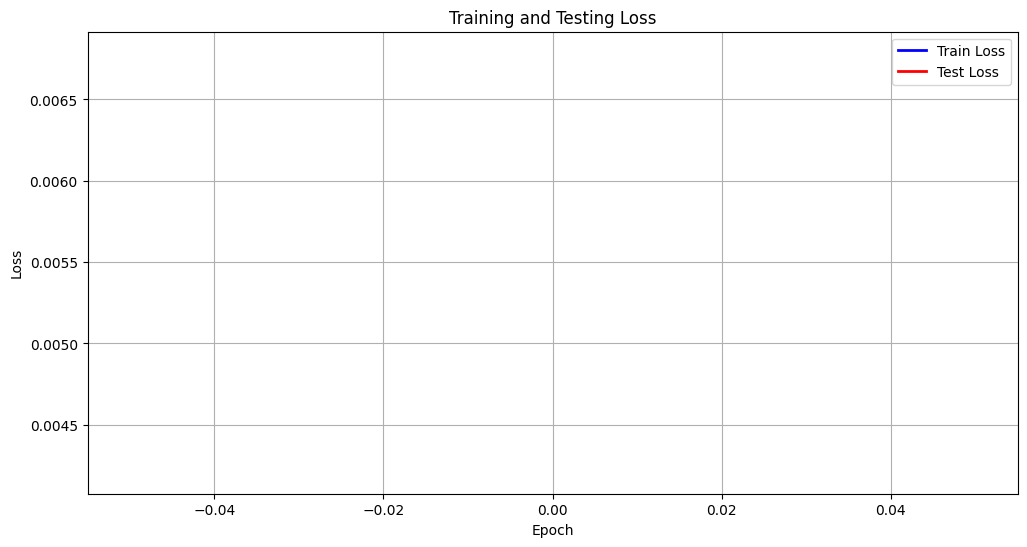

Training completed! Plots saved in fno_plots/


In [134]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-8)

train_losses = []
test_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for name, param in model.named_parameters():
        if param.data.isnan().any() or param.data.isinf().any():
            print(f"NaN/Inf detected in parameter {name} at epoch {epoch+1}")
            continue
    for batch_idx, data in pbar:
        if data['vil'].isnan().any() or data['vil'].isinf().any():
            print(f"NaN/Inf detected in input data at epoch {epoch+1}, batch {batch_idx}")
            continue

        vil_sequence = data['vil'].clone()  
        vil_sequence = vil_sequence.to('cuda')
        vil_sequence = vil_sequence.permute(0, 3, 1, 2)
        assert vil_sequence.shape[1] == 8, f"Expected 8 channels, got {vil_sequence.shape[1]}"
        input_frames = vil_sequence[:, :4]
        target_frames = vil_sequence[:, 4:]
        
        if torch.isnan(input_frames).any() or torch.isinf(input_frames).any() or \
           torch.isnan(target_frames).any() or torch.isinf(target_frames).any():
            print(f"NaN/Inf in input/target data at epoch {epoch+1}, batch {batch_idx}")
            print(f"Input min: {input_frames.min()}, max: {input_frames.max()}, has_nan: {torch.isnan(input_frames).any()}, has_inf: {torch.isinf(input_frames).any()}")
            print(f"Target min: {target_frames.min()}, max: {target_frames.max()}, has_nan: {torch.isnan(target_frames).any()}, has_inf: {torch.isinf(target_frames).any()}")
            continue

        predicted_frames = model(input_frames)

        if batch_idx == 0:
            plot(target_frames, predicted_frames, vil_colormap, vil_norm, epoch=epoch, batch_idx=batch_idx)

        if torch.isnan(predicted_frames).any() or torch.isinf(predicted_frames).any():
            print(f"NaN/Inf in predicted_frames at epoch {epoch+1}, batch {batch_idx}")
            print(f"Predicted min: {predicted_frames.min()}, max: {predicted_frames.max()}, has_nan: {torch.isnan(predicted_frames).any()}, has_inf: {torch.isinf(predicted_frames).any()}")
            continue

        loss = criterion(predicted_frames, target_frames)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss detected at epoch {epoch+1}, batch {batch_idx}")
            print(f"Loss value: {loss.item()}")
            print(f"Predicted min: {predicted_frames.min()}, max: {predicted_frames.max()}, has_nan: {torch.isnan(predicted_frames).any()}, has_inf: {torch.isinf(predicted_frames).any()}")
            print(f"Target min: {target_frames.min()}, max: {target_frames.max()}, has_nan: {torch.isnan(target_frames).any()}, has_inf: {torch.isinf(target_frames).any()}")
            break 
            
        optimizer.zero_grad()
        loss.backward()
    
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    print(f"NaN/Inf in gradient of {name} at epoch {epoch+1}, batch {batch_idx}")
                    grads_ok = False
                    nan_detected_in_epoch = True
                    break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
    # model.eval()
    epoch_test_losses = []
    # with torch.no_grad():
    #     test_pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
    #     for batch_idx, data in test_pbar:
    #         vil_sequence = data['vil']
    #         vil_sequence = vil_sequence.to('cuda')
    #         vil_sequence = vil_sequence.permute(0, 3, 1, 2)
    #         assert vil_sequence.shape[1] == 8, f"Expected 8 channels, got {vil_sequence.shape[1]}"
    #         input_frames = vil_sequence[:, :4]
    #         target_frames = vil_sequence[:, 4:]
            
    #         predicted_frames = model(input_frames)
    #         loss = criterion(predicted_frames, target_frames)
            
    #         epoch_test_losses.append(loss.item())
    #         test_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
            
    #         if batch_idx % 100 == 0:
    #             plot(target_frames, predicted_frames, vil_colormap, vil_norm, epoch=epoch, batch_idx=batch_idx)
                
    avg_train_loss = np.mean(epoch_train_losses)
    avg_test_loss = np.mean(epoch_test_losses)
    # train_losses.append(avg_train_loss)
    # test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, 'b-', linewidth=2, label='Train Loss')
plt.plot(test_losses, 'r-', linewidth=2, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

torch.save(model.state_dict(), f'fno_model_{int(time.time())}.pth')
print("Training completed! Plots saved in fno_plots/")